In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pySurrogate
import gwsurrogate
from gwsurrogate.new import spline_coef_evaluation
from gwsurrogate.new import surrogate
from gwsurrogate.new.spline_evaluation import fast_tensor_spline_eval

from numpy.linalg import norm

import tqdm
import sys, h5py

/home/balzani57/pool/anaconda3/envs/Python27/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


/home/balzani57/Repo/GitRepos/Codes/gwsurrogate/gwsurrogate/gwtools/gwtools.py:54: UserWarning: using non-LAL constants
  _warnings.warn("using non-LAL constants")


loading surrogate mode... l2_m0
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l2_m1
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l2_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l3_m1
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l3_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l3_m3
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l4_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l4_m3
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l4_m4
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l5_m2
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l5_m3
>>> tmin, tmax, dt are depricated as of 11/23/2016.
loading surrogate mode... l5_m4
>>> tmin, tmax, dt are depricated as of 11/2

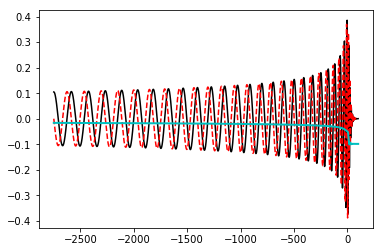

In [3]:
# Load amp/phase surrogate
sur = gwsurrogate.EvaluateSurrogate('/home/balzani57/Desktop/SurrogateFiles/SpEC_q1_10_NoSpin_nu5thDegPoly_exclude_2_0.h5',excluded=None)

# Evaluate it, make sure we get the (2, 0) mode as well
lm_modes, t, hreal, himag = sur(1.2, mode_sum=False, fake_neg_modes=False)
print lm_modes

plt.plot(t, hreal[:, 2], 'k')
plt.plot(t, himag[:, 2], 'r--')
plt.plot(t, hreal[:, 0], 'c', lw=2)
plt.show()

In [4]:
# We first need a complex empirical interpolant for each mode.
# Let's first determine how many basis vectors are needed (22 should be sufficient...)

def mode_evaluations(ell, m, nq):
    print 'Evaluating the (%s, %s) mode for %s mass ratios'%(ell, m, nq)
    sys.stdout.flush()
    qvals = np.linspace(1., 10., nq)
    evals = []
    for i in tqdm.trange(nq):
        q = qvals[i]
        lm_modes, t, hreal, himag = sur(q, mode_sum=False, fake_neg_modes=False, ell=[ell], m=[m])
        evals.append(hreal + 1.j*himag)
    return np.array(evals)

def max_proj_err(resids):
    return np.sqrt(np.max([abs(r.dot(r.conjugate())) for r in resids]))

def get_basis_and_errs(evals, tol):
    print 'getting basis...'
    sys.stdout.flush()
    basis = pySurrogate.ei.buildPySurSVD(evals, tol)
    coefs = np.sum(evals[:, :, np.newaxis] * basis.T.conjugate(), 1)
    errs = [max_proj_err(evals)]
    print 'getting projection errors...'
    sys.stdout.flush()
    for n in tqdm.trange(1, len(basis)+1):
        resids = evals - coefs[:, :n].dot(basis[:n])
        errs.append(max_proj_err(resids))
    return basis, errs

Evaluating the (8, 8) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 135.10it/s]

getting basis...


getting projection errors...


100%|██████████| 71/71 [00:09<00:00,  6.18it/s]


Evaluating the (2, 2) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 134.14it/s]

getting basis...


getting projection errors...


100%|██████████| 26/26 [00:03<00:00,  6.73it/s]

Evaluating the (3, 2) mode for 100 mass ratios



100%|██████████| 100/100 [00:00<00:00, 121.13it/s]

getting basis...


getting projection errors...


100%|██████████| 35/35 [00:04<00:00,  6.52it/s]


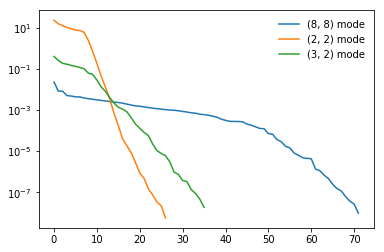

In [5]:
# Try out building a basis for the (ell, emm) mode
modes = [(8,8),(2,2),(3,2)]

nTS = 100 # Should be enough

for mode in modes:
    ell = mode[0]
    emm   = mode[1]
    hlm = mode_evaluations(ell, emm, nTS)
    basis, errs = get_basis_and_errs(hlm, 1.e-10)
    plt.semilogy(range(len(errs)), errs, label='(%i, %i) mode'%(ell,emm))

plt.legend(frameon=False)
plt.show()

In [6]:
# We know that a basis size of 22 should be enough.
# We could improve the computational cost by using a smaller basis for some modes.
# We could also build one single (larger) basis for all modes, which can accelerate RapidPE.
nTS = 100
basis_tol = 1.e-10
n_basis = 22

empirical_interpolant_bases = {}
orthogonal_bases = {}
empirical_node_indices = {}
vandermondes = {}


for i, (ell, m) in enumerate(lm_modes):
    mode_evals = mode_evaluations(ell, m, nTS)
    basis, errs = get_basis_and_errs(mode_evals, basis_tol)
    basis = basis[:n_basis]
    orthogonal_bases[ell,m] = basis
    errs = errs[:n_basis]
    print 'Largest projection error of final basis is %s'%(errs[-1])
    print 'Getting empirical interpolant...'
    sys.stdout.flush()
    ei_basis, node_indices, V = pySurrogate.ei.buildPySurEI(basis,returnV=True)
    reconstructed_basis = np.dot(V,ei_basis)
    diff = reconstructed_basis - basis
    print 'relative error from E - VB is %1.16e'%(norm(diff)/norm(basis))
    sys.stdout.flush()
    empirical_interpolant_bases[ell, m] = ei_basis
    empirical_node_indices[ell, m] = node_indices
    vandermondes[ell, m] = V

Evaluating the (2, 0) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 165.21it/s]

getting basis...


getting projection errors...


100%|██████████| 7/7 [00:00<00:00,  7.28it/s]

Largest projection error of final basis is 1.68420278055406e-08
Getting empirical interpolant...
relative error from E - VB is 1.6507721902258347e-15
Evaluating the (2, 1) mode for 100 mass ratios



100%|██████████| 100/100 [00:00<00:00, 144.30it/s]


getting basis...
getting projection errors...


100%|██████████| 24/24 [00:02<00:00,  7.76it/s]

Largest projection error of final basis is 1.4074306653279305e-07
Getting empirical interpolant...


relative error from E - VB is 1.3285967608250692e-15
Evaluating the (2, 2) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 152.58it/s]

getting basis...


getting projection errors...


100%|██████████| 26/26 [00:03<00:00,  7.67it/s]

Largest projection error of final basis is 4.788091482544899e-07
Getting empirical interpolant...


relative error from E - VB is 1.3966641890043281e-15
Evaluating the (3, 1) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 146.21it/s]


getting basis...
getting projection errors...


100%|██████████| 34/34 [00:04<00:00,  7.26it/s]

Largest projection error of final basis is 4.079777934463323e-05
Getting empirical interpolant...


relative error from E - VB is 2.7667149562339511e-15
Evaluating the (3, 2) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 149.52it/s]


getting basis...
getting projection errors...


100%|██████████| 35/35 [00:04<00:00,  7.20it/s]

Largest projection error of final basis is 8.28813487698191e-05
Getting empirical interpolant...


relative error from E - VB is 1.4642689464637922e-15
Evaluating the (3, 3) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 142.46it/s]


getting basis...
getting projection errors...


100%|██████████| 33/33 [00:04<00:00,  6.58it/s]

Largest projection error of final basis is 0.00011357565235256758
Getting empirical interpolant...


relative error from E - VB is 1.0511409480962504e-15
Evaluating the (4, 2) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 148.19it/s]


getting basis...
getting projection errors...


100%|██████████| 33/33 [00:04<00:00,  7.15it/s]

Largest projection error of final basis is 1.8080156306840385e-05
Getting empirical interpolant...


relative error from E - VB is 2.1733796076048458e-15
Evaluating the (4, 3) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 139.74it/s]

getting basis...


getting projection errors...


100%|██████████| 37/37 [00:04<00:00,  7.04it/s]

Largest projection error of final basis is 0.00014668151586945922
Getting empirical interpolant...


relative error from E - VB is 9.0456335096605527e-16
Evaluating the (4, 4) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 148.20it/s]


getting basis...
getting projection errors...


100%|██████████| 41/41 [00:05<00:00,  6.21it/s]

Largest projection error of final basis is 0.000967968481897997
Getting empirical interpolant...


relative error from E - VB is 8.6611459095295605e-16
Evaluating the (5, 2) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 146.39it/s]


getting basis...
getting projection errors...


100%|██████████| 37/37 [00:04<00:00,  6.89it/s]

Largest projection error of final basis is 6.2217083629728696e-06
Getting empirical interpolant...


relative error from E - VB is 2.7153111378270970e-15
Evaluating the (5, 3) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 133.43it/s]

getting basis...


getting projection errors...


100%|██████████| 38/38 [00:04<00:00,  6.96it/s]

Largest projection error of final basis is 7.754716199720526e-05
Getting empirical interpolant...


relative error from E - VB is 1.3472272961380028e-15
Evaluating the (5, 4) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 170.72it/s]


getting basis...
getting projection errors...


100%|██████████| 44/44 [00:06<00:00,  6.18it/s]

Largest projection error of final basis is 0.00032047783798658475
Getting empirical interpolant...


relative error from E - VB is 8.1375928847636285e-16
Evaluating the (5, 5) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 158.14it/s]

getting basis...


getting projection errors...


100%|██████████| 48/48 [00:06<00:00,  6.56it/s]

Largest projection error of final basis is 0.0024595773682491687
Getting empirical interpolant...


relative error from E - VB is 1.1468096051575587e-15
Evaluating the (6, 3) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 157.51it/s]

getting basis...


getting projection errors...


100%|██████████| 36/36 [00:04<00:00,  7.06it/s]

Largest projection error of final basis is 3.927699247621426e-06
Getting empirical interpolant...


relative error from E - VB is 1.7775030519183595e-15
Evaluating the (6, 4) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 164.53it/s]

getting basis...


getting projection errors...


100%|██████████| 42/42 [00:05<00:00,  6.39it/s]

Largest projection error of final basis is 0.00012181272505517338
Getting empirical interpolant...


relative error from E - VB is 1.2202739219567414e-15
Evaluating the (6, 5) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 144.21it/s]


getting basis...
getting projection errors...


100%|██████████| 46/46 [00:06<00:00,  6.14it/s]

Largest projection error of final basis is 0.00025127726463293075
Getting empirical interpolant...


relative error from E - VB is 1.1517038046751862e-15
Evaluating the (6, 6) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 103.21it/s]

getting basis...


getting projection errors...


100%|██████████| 57/57 [00:08<00:00,  6.05it/s]

Largest projection error of final basis is 0.0072296871900004965
Getting empirical interpolant...


relative error from E - VB is 6.9308588001956941e-16
Evaluating the (7, 5) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 159.73it/s]

getting basis...


getting projection errors...


100%|██████████| 48/48 [00:07<00:00,  6.30it/s]

Largest projection error of final basis is 9.42918786470115e-05
Getting empirical interpolant...


relative error from E - VB is 1.1256855805041564e-15
Evaluating the (7, 6) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 166.27it/s]


getting basis...
getting projection errors...


100%|██████████| 52/52 [00:07<00:00,  6.28it/s]

Largest projection error of final basis is 0.00025573155738105985
Getting empirical interpolant...


relative error from E - VB is 1.4210075216491305e-15
Evaluating the (7, 7) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 149.49it/s]


getting basis...
getting projection errors...


100%|██████████| 61/61 [00:10<00:00,  4.23it/s]

Largest projection error of final basis is 0.0029557563796381607
Getting empirical interpolant...
relative error from E - VB is 1.1325559208536605e-15
Evaluating the (8, 6) mode for 100 mass ratios



100%|██████████| 100/100 [00:01<00:00, 75.88it/s]


getting basis...
getting projection errors...


100%|██████████| 53/53 [00:08<00:00,  6.00it/s]

Largest projection error of final basis is 6.332958043988102e-05
Getting empirical interpolant...


relative error from E - VB is 1.5476784525796870e-15
Evaluating the (8, 7) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 161.51it/s]

getting basis...


getting projection errors...


100%|██████████| 65/65 [00:10<00:00,  5.39it/s]

Largest projection error of final basis is 0.0001482652691743836
Getting empirical interpolant...


relative error from E - VB is 1.4083959285962340e-15
Evaluating the (8, 8) mode for 100 mass ratios


100%|██████████| 100/100 [00:00<00:00, 155.47it/s]

getting basis...


getting projection errors...


100%|██████████| 71/71 [00:12<00:00,  5.68it/s]

Largest projection error of final basis is 0.0014419396827700934
Getting empirical interpolant...


relative error from E - VB is 1.5679646080421572e-15


(12,)


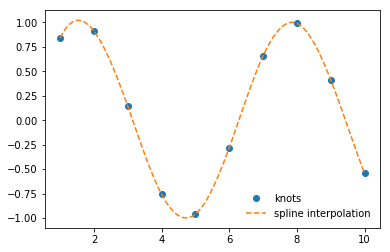

In [7]:
# Now we need to build a spline for the real/imaginary parts of each empirical node.
# For simplicity we will use the same knots for all modes and nodes.

# Here's how we build a simple spline:
nQ = 10
qvals = np.linspace(1., 10., nQ)
yvals = np.sin(qvals)
spline = spline_coef_evaluation.UniformSpacingCubicSplineND((nQ,))
coefs = spline.solve(yvals) # Use the LU decomposition to obtain spline coefficients

print coefs.shape

# And we can evaluate it:
ts_grid = surrogate.TensorSplineGrid([qvals])

def eval_spline(ts_grid, coefs, x):
    # Nudge to avoid being outside valid range
    if x - 10. > -1.e-12:
        x = 10. - 1.e-12
    if x < 1.e-12:
        x = 1.e-12
        
    #imin_vals, eval_prods = ts_grid([x])
    #i0 = imin_vals[0]
    eval_prods, sl, summed_axes = ts_grid(np.array([x]))
    #print sl[1]
    #print eval_prods
    #print summed_axes
    return np.sum(coefs[sl[1]] * eval_prods)

qtest = np.linspace(1., 10., nQ * 10)
ytest = np.array([eval_spline(ts_grid, coefs, q) for q in qtest])
plt.plot(qvals, yvals, 'o', label='knots')
plt.plot(qtest, ytest, '--', label='spline interpolation')
plt.legend(frameon=False)
plt.show()


In [8]:
def simple_spline_errors(nQ, nQTest):
    qvals = np.linspace(1., 10., nQ)
    yvals = np.sin(qvals)
    spline = spline_coef_evaluation.UniformSpacingCubicSplineND((nQ,))
    coefs = spline.solve(yvals)
    ts_grid = surrogate.TensorSplineGrid([qvals])
    qtest = np.linspace(1., 10., nQTest)
    ytest = np.array([eval_spline(ts_grid, coefs, q) for q in qtest])
    return abs(ytest - np.sin(qtest))

100%|██████████| 11/11 [00:29<00:00,  4.94s/it]


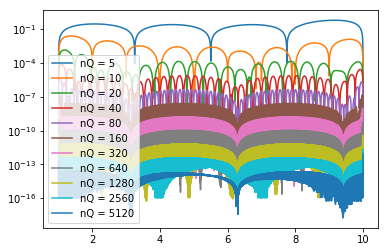

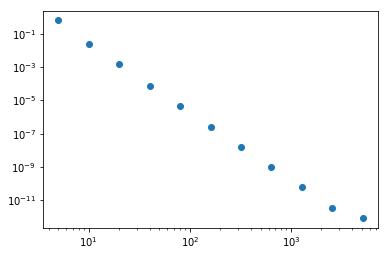

In [9]:
# Let's show that a simple spline converges well:
nqvals = [5]
for i in range(10):
    nqvals.append(2 * nqvals[-1])
nQTest = nqvals[-1] * 2
qtest = np.linspace(1., 10., nQTest)
errs = []
for i in tqdm.trange(len(nqvals)):
    nq = nqvals[i]
    errs.append(simple_spline_errors(nq, nQTest))

for i, nq in enumerate(nqvals):
    plt.semilogy(qtest, errs[i], label='nQ = %s'%(nq))
plt.legend()
plt.show()

plt.loglog(nqvals, [np.max(err) for err in errs], 'o')
plt.show()

In [10]:
# Now let's build a whole spline surrogate

def get_mode_spline_coefs(ell, m, qvals, spline):
    node_indices = empirical_node_indices[ell, m]
    real_nodes = []
    imag_nodes = []
    for q in qvals:
        lm_modes, t, hreal, himag = sur(q, mode_sum=False, fake_neg_modes=False, ell=[ell], m=[m])
        real_nodes.append(hreal[node_indices])
        imag_nodes.append(himag[node_indices])
    
    real_nodes = np.array(real_nodes)
    imag_nodes = np.array(imag_nodes)
    real_coefs = []
    imag_coefs = []
    for i in range(len(node_indices)):
        real_coefs.append(spline.solve(real_nodes[:, i]))
        imag_coefs.append(spline.solve(imag_nodes[:, i]))
    return np.array(real_coefs), np.array(imag_coefs)

def build_spline_surrogate(nQ):
    qvals = np.linspace(1., 10., nQ)
    spline = spline_coef_evaluation.UniformSpacingCubicSplineND((nQ,))
    
    mode_data = {}
    for i in tqdm.trange(len(lm_modes)):
        ell, m = lm_modes[i]
        real_coefs, imag_coefs = get_mode_spline_coefs(ell, m, qvals, spline)
        
        # empirical_interpolant_bases are found a few cells up
        mode_data[ell, m] = (empirical_interpolant_bases[ell, m], real_coefs, imag_coefs)
        
    spline_surrogate = surrogate.FastTensorSplineSurrogate(
            name = 'SpEC_1d_nonspinning_%s_spline_knots',
            domain = t,
            param_space = surrogate.ParamSpace('Nonspinning_q10', [surrogate.ParamDim('q', 1, 10)]),
            knot_vecs = [qvals],
            mode_data = mode_data,
            modes = lm_modes,
    )
    
    return spline_surrogate

def waveform_norm(h):
    return np.sqrt(np.sum(abs(h**2)))

def waveform_error(h1, h2):
    return waveform_norm(h1 - h2) / waveform_norm(h1)

def many_h_evals(qvals):
    h_evals = []
    for i in tqdm.trange(len(qvals)):
        q = qvals[i]
        _, t, hreal, himag = sur(q, mode_sum=False, fake_neg_modes=False)
        h_evals.append((hreal + 1.j*himag).T)
    return h_evals

def test_spline_surrogate(spline_surrogate, nqtest, h_evals):
    qtest = np.linspace(1., 10., nqtest)
    errs = []
    for i in tqdm.trange(len(qtest)):
        q = qtest[i]
        h = h_evals[i]
        spline_modes = spline_surrogate([q])
        h_spline = np.array([spline_modes[k] for k in lm_modes])
        errs.append(waveform_error(h, h_spline))
    return np.array(errs)

In [11]:
errs = []
nqs = [5, 10, 20, 40, 80]
nqtest = 150
qtest = np.linspace(1., 10., nqtest)
h_evals = many_h_evals(qtest)
for nq in nqs:
    spline_sur = build_spline_surrogate(nq)
    errs.append(test_spline_surrogate(spline_sur, nqtest, h_evals))
    print nq, np.max(errs[-1])
    sys.stdout.flush()

100%|██████████| 150/150 [00:09<00:00, 16.65it/s]

5 2.0242537131283784



100%|██████████| 150/150 [00:09<00:00, 15.32it/s]

10 1.5276969199011152



100%|██████████| 150/150 [00:10<00:00, 12.79it/s]

20 0.4523800093596668



100%|██████████| 150/150 [00:09<00:00, 15.08it/s]

40 0.020489430667611223



100%|██████████| 150/150 [00:09<00:00, 16.22it/s]

80 0.0014766369778754734


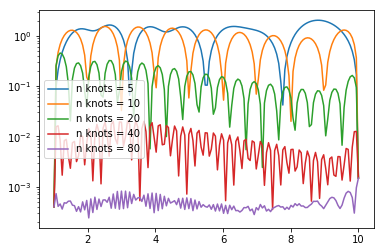

In [12]:
for nq, err in zip(nqs, errs):
    plt.semilogy(qtest, err, label='n knots = %s'%(nq))
plt.legend()
plt.show()

In [13]:
# Add a couple more (better) spline surrogates...
nqs = nqs + [160, 320]
for nq in [160, 320]:
    spline_sur = build_spline_surrogate(nq)
    errs.append(test_spline_surrogate(spline_sur, nqtest, h_evals))
    print nq, np.max(errs[-1])
    sys.stdout.flush()

100%|██████████| 150/150 [00:10<00:00, 14.83it/s]

160 0.0014766369779417462



100%|██████████| 150/150 [00:10<00:00, 14.21it/s]

320 0.001476636977946422


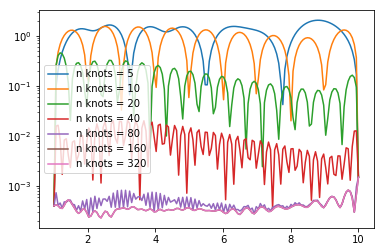

In [14]:
for nq, err in zip(nqs, errs):
    plt.semilogy(qtest, err, label='n knots = %s'%(nq))
plt.legend()
plt.show()

In [15]:
# It looks like we reach the empirical interpolation error cutoff around 100 knots.
spline_sur = build_spline_surrogate(100)

100%|██████████| 23/23 [00:13<00:00,  1.69it/s]


In [16]:
%%timeit
spline_sur([1.2])

10 loops, best of 3: 18.3 ms per loop


In [17]:
%%timeit
sur(1.2, mode_sum=False, fake_neg_modes=False)

1 loop, best of 3: 131 ms per loop


In [18]:
# Save the spline surrogate:
spline_sur.save('SpEC_q10_nonspinning_spline_surrogate_v1.h5')

Evaluation of SpEC_q10_nonspinning_spline_surrogate_v1.h5, and comparison to the original surrogate has been moved to the notebook tutorial/numerical_relativity.ipynb

# save tensor spline surrogate in old gwsurrogate format


In [ ]:
%load_ext autoreload
%autoreload

from gwsurrogate.new import surrogate
from gwsurrogate import surrogateIO

import gwsurrogate
from gwsurrogate.new import spline_coef_evaluation
from gwsurrogate.new.spline_evaluation import cubic_spline_breaksToknots
from gwsurrogate.new import surrogate

In [ ]:
loaded_surrogate = surrogate.FastTensorSplineSurrogate()
loaded_surrogate.load('SpEC_q10_nonspinning_spline_surrogate_v1.h5')

In [ ]:
# Q: Where are EIM indicies? (how does mode get evaluated with ei and spline data?)
# other data needed for gwsurrogate?
# Q: data for parameter domain? 
# Q: data for affine map?
print loaded_surrogate.param_space
print loaded_surrogate.name
print loaded_surrogate.mode_list
print loaded_surrogate.mode_indices
print loaded_surrogate.domain
print len(loaded_surrogate.cre)
print len(loaded_surrogate.cim)
print len(loaded_surrogate.ei)
print loaded_surrogate.ei[2].shape
print loaded_surrogate.cre[2].shape
print loaded_surrogate.ts_grid.breakpoint_vecs[0].shape
print loaded_surrogate._h5_data_keys # what is this used for?
print loaded_surrogate._h5_subordinate_keys # what is this used for?

In [ ]:
# Q: not exactly 100? OK?
# Q: not exactly dt=.1? OK?
print spline_sur.domain[0]
print spline_sur.domain[-1]
print spline_sur.domain[1] - spline_sur.domain[0]

In [ ]:
writeh5 = surrogateIO.H5Surrogate('SpEC_q1_10_NoSpin_nu5thDegPoly_exclude_2_0_FastSplined_WithVandermonde.h5','w')

In [ ]:
### store surrogate data in old gws format ###
# Note: loaded_surrogate does NOT have vandermonde data. 
# This data should be in the notebook's namespace if loaded_surrogate was built using the notebook (see earlier cell)
last_mode = str(loaded_surrogate.mode_list[-1])
for mode in loaded_surrogate.mode_list:
    mode = str(mode)
    mode_index = loaded_surrogate.mode_indices[str(mode)]

    surrogate_mode_data = {}
    surrogate_mode_data["surrogate_mode_type"] = 'waveform_basis'
    surrogate_mode_data['parameterization']  = 'q_to_q'
    surrogate_mode_data['affine_map'] = 'none'
    surrogate_mode_data['t_units'] = 'TOverMtot'
    surrogate_mode_data['B'] = loaded_surrogate.ei[mode_index]
    surrogate_mode_data['V'] = vandermondes[(int(mode[1]),int(mode[4]))]
    surrogate_mode_data['fit_min'] = 1.0
    surrogate_mode_data['fit_max'] = 10.0
    surrogate_mode_data['times'] = loaded_surrogate.domain
    bvecs = loaded_surrogate.ts_grid.breakpoint_vecs[0] # [0] = BAD! 
    surrogate_mode_data['spline_knots'] = cubic_spline_breaksToknots(bvecs)
    surrogate_mode_data['fitparams_amp'] = loaded_surrogate.cre[mode_index]
    surrogate_mode_data['fitparams_phase'] = loaded_surrogate.cim[mode_index]
    surrogate_mode_data['fit_type_phase'] = 'fast_spline_imag'
    surrogate_mode_data['fit_type_amp'] = 'fast_spline_real'

    save_subdir = 'l'+mode[1]+'_m'+mode[4]
    print('saving mode %s'%save_subdir)
    if last_mode == mode:
        writeh5.write_h5(surrogate_mode_data,subdir=save_subdir,closeQ=True)
    else:
        writeh5.write_h5(surrogate_mode_data,subdir=save_subdir,closeQ=False)


# Q: fit amp/phase instead of h? how was (2,0) mode fitted?
# Q: how does tmin/tmax/dt and times fit together? Always include just times at which basis is sampled? a bit more
# space but less confusing
#surrogate_mode_data['tmin'] = spline_sur.domain[-1]
#surrogate_mode_data['tmax'] = spline_sur.domain[0]
#surrogate_mode_data['dt'] = spline_sur.domain[1] - spline_sur.domain[0]
#surrogate_mode_data['quadrature_weights'] =
# Q: data set has no eim_indices. 
#_eim_indices_grp        = 'eim_indices'       # .txt... text: eim_indices contains 2 vectors if amp/phase
#_eim_indices_phase_grp  = 'eim_indices_phase' # rolled into eim_indices

# _eim_amp_grp    = 'eim_amp' # text analog? only used to plot 
#  _eim_phase_grp  = 'eim_phase' # text analog? only used to plot

#  _fitparams_phase_grp      = 'fitparams_phase' #  .txt
#  _fit_type_phase_grp       = 'fit_type_phase'   # .txt
#  _fitparams_amp_grp        = 'fitparams_amp'  # .txt
#  _fit_type_amp_grp         = 'fit_type_amp' # .txt
#  _fit_type_norm_grp        = 'fit_type_norm' # .txt
#  _fitparams_norm_grp       = 'fitparams_norm' # .txt

In [26]:
sur_new = gwsurrogate.EvaluateSurrogate('/home/balzani57/Desktop/SurrogateFiles/SpEC_q1_10_NoSpin_nu5thDegPoly_exclude_2_0_FastSplined_WithVandermonde.h5')

loading surrogate mode... l2_m0

>>> Warning: Guessing quadrature weights to be identical with 0.100000
Cannot load greedy points...OK
Cannot load eim points...OK
Special case: using fast tensor spline for real and imaginary parts instead of amp/phase
Loading fast tensor spline breakpoints
loading surrogate mode... l2_m1

>>> Warning: Guessing quadrature weights to be identical with 0.100000
Cannot load greedy points...OK
Cannot load eim points...OK
Special case: using fast tensor spline for real and imaginary parts instead of amp/phase
Loading fast tensor spline breakpoints
loading surrogate mode... l2_m2

>>> Warning: Guessing quadrature weights to be identical with 0.100000
Cannot load greedy points...OK
Cannot load eim points...OK
Special case: using fast tensor spline for real and imaginary parts instead of amp/phase
Loading fast tensor spline breakpoints
loading surrogate mode... l3_m1

>>> Warning: Guessing quadrature weights to be identical with 0.100000
Cannot load greedy poin

[(2, 0), (2, 1), (2, 2), (3, 1), (3, 2), (3, 3), (4, 2), (4, 3), (4, 4), (5, 2), (5, 3), (5, 4), (5, 5), (6, 3), (6, 4), (6, 5), (6, 6), (7, 5), (7, 6), (7, 7), (8, 6), (8, 7), (8, 8)]


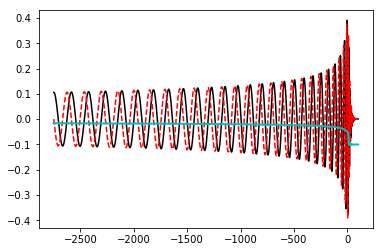

In [27]:
#%matplotlib auto

# Evaluate it, make sure we get the (2, 0) mode as well
lm_modes, t, hreal, himag = sur_new(1.0, mode_sum=False, fake_neg_modes=False)
print lm_modes

plt.plot(t, hreal[:, 2], 'k')
plt.plot(t, himag[:, 2], 'r--')
plt.plot(t, hreal[:, 0], 'c', lw=2)
plt.show()

NOTE: more comparisons are found in the notebook tutorial/numerical_relativity.ipynb

In [28]:
## compare tensor spline surrogate to original 
def test_spline_surrogate_old_gws(spline_surrogate, nqtest, h_evals):
    qtest = np.linspace(1., 10., nqtest)
    errs = []
    
    # evaluate spline surrogate with old gws framework
    for i in tqdm.trange(len(qtest)):
        q = qtest[i]
        h = h_evals[i]
        _, t, hreal, himag = spline_surrogate(q, mode_sum=False, fake_neg_modes=False)
        h_evals_splined = (hreal + 1.j*himag).T
        
        errs.append(waveform_error(h, h_evals_splined))
        
    return np.array(errs)


100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


[0.0003984  0.0004112  0.00035948 0.00036792 0.00048929 0.00051048
 0.00041855 0.00033252 0.00028102 0.00032354 0.00034086 0.00025792
 0.00025011 0.00031218 0.0002912  0.00022727 0.00027508 0.00031066
 0.00025017 0.00025931 0.00032934 0.00034676 0.00035654 0.00035709
 0.00033836 0.00036977 0.00038036 0.00033967 0.00033906 0.0003344
 0.00031806 0.00034358 0.000325   0.0002996  0.00033325 0.00032851
 0.00031502 0.00033423 0.00032799 0.00033129 0.00035422 0.00033963
 0.00032827 0.00035885 0.0003628  0.00032897 0.00032563 0.00034767
 0.00034112 0.00032109 0.00031965 0.00031827 0.00031209 0.00032268
 0.00032829 0.00030026 0.00027916 0.0003141  0.00034724 0.00032145
 0.00027087 0.00028833 0.00034849 0.00036058 0.00031203 0.00027551
 0.00031674 0.00037185 0.00037576 0.00033366 0.00030369 0.00032922
 0.00037305 0.0003887  0.00037111 0.00034715 0.00034677 0.00037129
 0.00040054 0.00041812 0.00041497 0.00039054 0.00036869 0.00039421
 0.00046199 0.00050528 0.00047413 0.00039086 0.00037795 0.00049

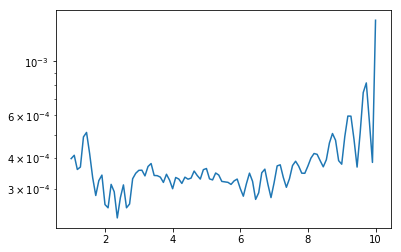

In [29]:
#%matplotlib inline
nqtest = 100
#qtest = np.array([1.])
qtest = np.linspace(1., 10., nqtest)
h_evals = many_h_evals(qtest)
loaded_err = test_spline_surrogate_old_gws(sur_new, nqtest, h_evals)

print loaded_err

plt.semilogy(qtest, loaded_err, label='n knots = %s'%(nq))



In [32]:
print "3,3 mode looks crappy... why?"
# Test E = BV^{-1} relationship
for mode, single_mode_sur in sur_new.single_mode_dict.iteritems():
    V = single_mode_sur.V
    B = single_mode_sur.B
    E = np.dot(B,V)
    print mode
    print norm(E)
    print norm(E - orthogonal_bases[mode].T) / norm(E)

(6, 6)
4.690415759823425
1.7145739794977697e-14
(5, 4)
4.6904157598234315
6.887256554209698e-14
(2, 1)
4.6904157598234395
3.788462096856972e-09
(3, 3)
4.690415759823433
0.4264014327112202
(7, 6)
4.690415759823443
5.212372502608819e-14
(4, 4)
4.690415759823434
5.152476233950616e-13
(6, 3)
4.690415759823434
1.46084572462954e-13
(2, 2)
4.690415759823441
1.3658235516494783e-08
(8, 6)
4.690415759823414
2.958108748723794e-14
(5, 3)
4.690415759823423
1.1897044159117583e-13
(6, 4)
4.690415759823427
3.3900109941748496e-14
(3, 2)
4.690415759823418
1.4877051013268283e-12
(7, 7)
4.690415759823428
2.6821878404110845e-14
(7, 5)
4.690415759823432
2.1213829625838754e-14
(8, 7)
4.690415759823437
5.1962717385868015e-14
(4, 2)
4.690415759823413
8.355195038150502e-13
(6, 5)
4.690415759823418
3.1667753653223e-14
(5, 5)
4.690415759823417
3.8925837027638546e-14
(3, 1)
4.690415759823435
9.740841399910825e-13
(2, 0)
2.645751311064589
1.8452102588602088e-08
(8, 8)
4.690415759823446
3.688420570725932e-14
(4, 3)
